In [1]:
from astropy.io import fits
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
allstar_dr16 = fits.getdata('/Users/apricewhelan/data/APOGEE_DR16/allStar-r12-l33.fits', 1)
allvisit_dr16 = fits.getdata('/Users/apricewhelan/data/APOGEE_DR16/allVisit-r12-l33.fits', 1)

In [3]:
new_name = 'r14-202010'
allstar_new = fits.getdata('/Users/apricewhelan/data/APOGEE_beta/allField-r14-202010.fits')
allvisit_new = fits.getdata('/Users/apricewhelan/data/APOGEE_beta/allFieldVisit-r14-202010.fits', 1)

## RV comparisons

Questions for Jon:

- Why are there NAN RA/DEC values?
- Why are there DEC values -99.9990005493 ?!?
- What are the differences between N_COMPONENTS=[0,1,-1]
- In what situations can something get N_COMPONENTS=2 but RV_COMPONENTS = 0.?
- Is the same Cannon spectrum CCF'd to the visit spectra? If so, this will bias to equal-mass (or equal temperature) binaries, right?

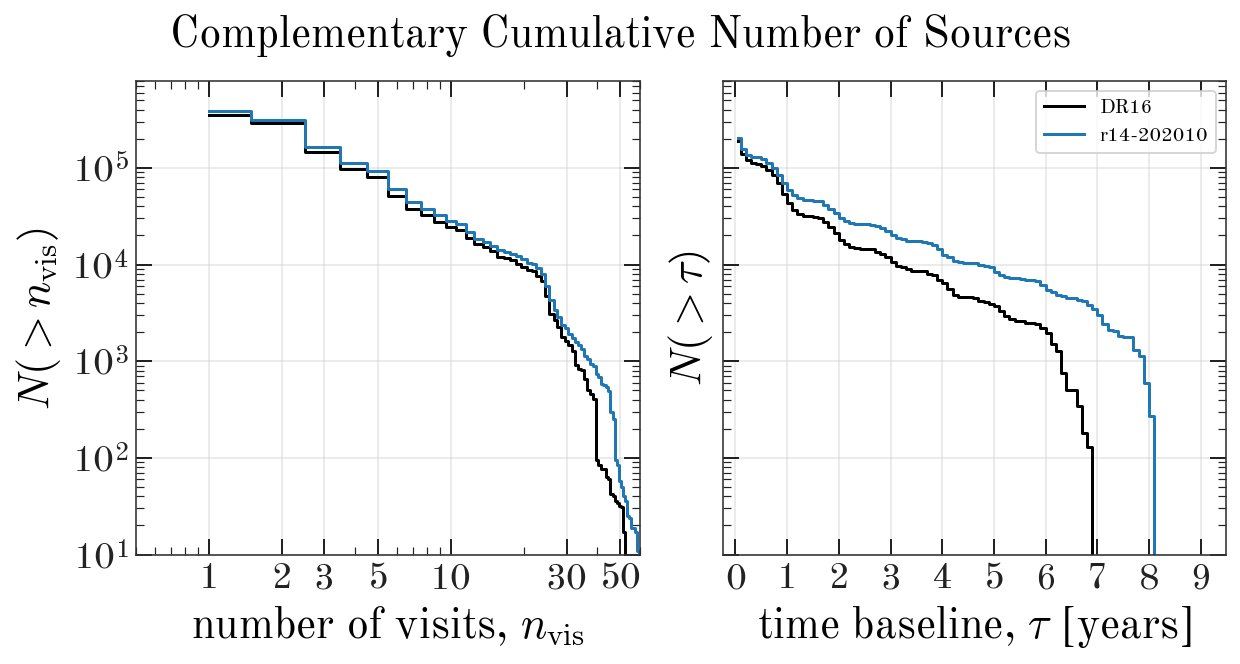

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(8.5, 4.5), sharey=True, 
                         constrained_layout=True)

ax = axes[0]

ax.set_xscale('log')

ax.xaxis.set_ticks([1, 2, 3, 5, 10, 30, 50])
ax.xaxis.set_ticklabels(np.array([1, 2, 3, 5, 10, 30, 50]).astype(str))

ax.set_xlim(0.5, 60)

ax.set_xlabel(r'number of visits, $n_{\rm vis}$')
ax.set_ylabel(r'$N(> n_{\rm vis}$)')

ax.grid(which='major', axis='both', zorder=-10, alpha=0.5)

# ---

ax = axes[1]

ax.set_yscale('log')
ax.set_xlabel(r'time baseline, $\tau$ [years]')

ax.xaxis.set_ticks(np.arange(0, 10, 1))
ax.set_xlim(-0.25, 9.5)

ax.yaxis.set_ticks(10**np.arange(1, 5+1, 1))
_ticks = np.concatenate([10**i * np.arange(10) for i in range(0, 6)])
ax.yaxis.set_ticks(_ticks, minor=True)
ax.set_ylim(1e1, 8e5)

ax.grid(which='major', axis='both', zorder=-10, alpha=0.5)

ax.set_ylabel(r'$N(> \tau$)')

fig.suptitle('Complementary Cumulative Number of Sources', fontsize=22)

# ---

for allvisit, name in zip([allvisit_dr16, allvisit_new],
                          ['DR16', new_name]):
    t = at.Table()
    for col in ['APOGEE_ID', 'JD', 'VHELIO']:
        t[col] = allvisit[col]
    df = t.to_pandas()

    g = df.groupby('APOGEE_ID')

    baseline = g['JD'].apply(np.ptp)
    baseline_yr = baseline / 365.25
    nvisits = g['APOGEE_ID'].count()
    
    # ---
    
    H, xe = np.histogram(nvisits, bins=np.arange(0.5, 60.5+1, 1))
    xctr = 0.5 * (xe[:-1] + xe[1:])
    axes[0].plot(xctr, H.sum() - np.cumsum(H), 
                 marker='', drawstyle='steps-mid')
    
    
    H, xe = np.histogram(baseline_yr, bins=np.arange(0, 3000/365, 0.1))
    xctr = 0.5 * (xe[:-1] + xe[1:])
    axes[1].plot(xctr, H.sum() - np.cumsum(H), 
                 marker='', drawstyle='steps-mid', label=name)
    axes[1].legend(loc='upper right')

Check for RV_FAIL:

In [151]:
rv_flags_mask = np.array(['RV_FAIL' in x for x in allstar_new['STARFLAGS']])
rv_flags_mask.sum(), len(rv_flags_mask)

(3856, 708316)

In [162]:
tmp = allstar_new[rv_flags_mask]
visits = allvisit_new[allvisit_new['APOGEE_ID'] == tmp['APOGEE_ID'][6]]
print(visits['APOGEE_ID'], tmp['APOGEE_ID'][6])
len(visits), visits['VHELIO']

['2M17442065-2626057'] 2M17442065-2626057


(1, array([6.24578333]))

In [144]:
tmp = np.array(['RV_FAIL' in x for x in allvisit_new['STARFLAGS']])
tmp.sum()

0

In [20]:
allvisit_new['N_COMPONENTS'][np.isin(allvisit_new['APOGEE_ID'], allstar_new[rv_flags_mask]['APOGEE_ID'])]

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
apogee_ids = np.unique(allvisit_new['APOGEE_ID'][allvisit_new['N_COMPONENTS'] == 0])
allstar_new['STARFLAGS'][np.isin(allstar_new['APOGEE_ID'], apogee_ids)]

chararray(['PERSIST_HIGH', '', '', ..., '', '', 'LOW_SNR'], dtype='<U132')

In [23]:
apogee_ids = np.unique(allvisit_new['APOGEE_ID'][allvisit_new['N_COMPONENTS'] == -1])
allstar_new['STARFLAGS'][np.isin(allstar_new['APOGEE_ID'], apogee_ids)]

chararray(['', '', '', ..., '', '', ''], dtype='<U132')

In [22]:
tmp = allvisit_new[np.isin(allvisit_new['APOGEE_ID'],
                           allstar_new[allstar_new['N_COMPONENTS'] > 1]['APOGEE_ID'])]
tmp[tmp['RV_COMPONENTS'][:, 1] == 0.]['APOGEE_ID']

chararray(['2M17525147-2936107', '2M17295454-2708209',
           '2M17404291-2754099', ..., '2M05384011-0659148',
           '2M05373898-0645154', '2M05331648-0735151'], dtype='<U19')

In [23]:
allvisit_new[allvisit_new['APOGEE_ID'] == '2M17404291-2754099']['N_COMPONENTS']

array([1, 1, 1])

In [24]:
allvisit_new[allvisit_new['APOGEE_ID'] == '2M17404291-2754099']['RV_COMPONENTS']

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [26]:
allstar_new[allstar_new['APOGEE_ID'] == '2M17404291-2754099']['N_COMPONENTS']

array([1, 2])

array([False, False, False, ..., False, False, False])

Check Gaia CMD location for N_COMPONENTS>1 stars

In [55]:
allstar_sub = allstar_new[((allstar_new['GAIA_PARALLAX'] / allstar_new['GAIA_PARALLAX_ERROR']) > 8) &
                          (allstar_new['GAIA_PHOT_BP_MEAN_MAG'] != allstar_new['GAIA_PHOT_RP_MEAN_MAG']) &
                          (np.abs(allstar_new['GLAT']) > 15)]
len(allstar_sub)

361998

In [56]:
DM = coord.Distance(parallax=allstar_sub['GAIA_PARALLAX']*u.mas).distmod.value
MG = allstar_sub['GAIA_PHOT_G_MEAN_MAG'] - DM
BPRP = allstar_sub['GAIA_PHOT_BP_MEAN_MAG'] - allstar_sub['GAIA_PHOT_RP_MEAN_MAG']

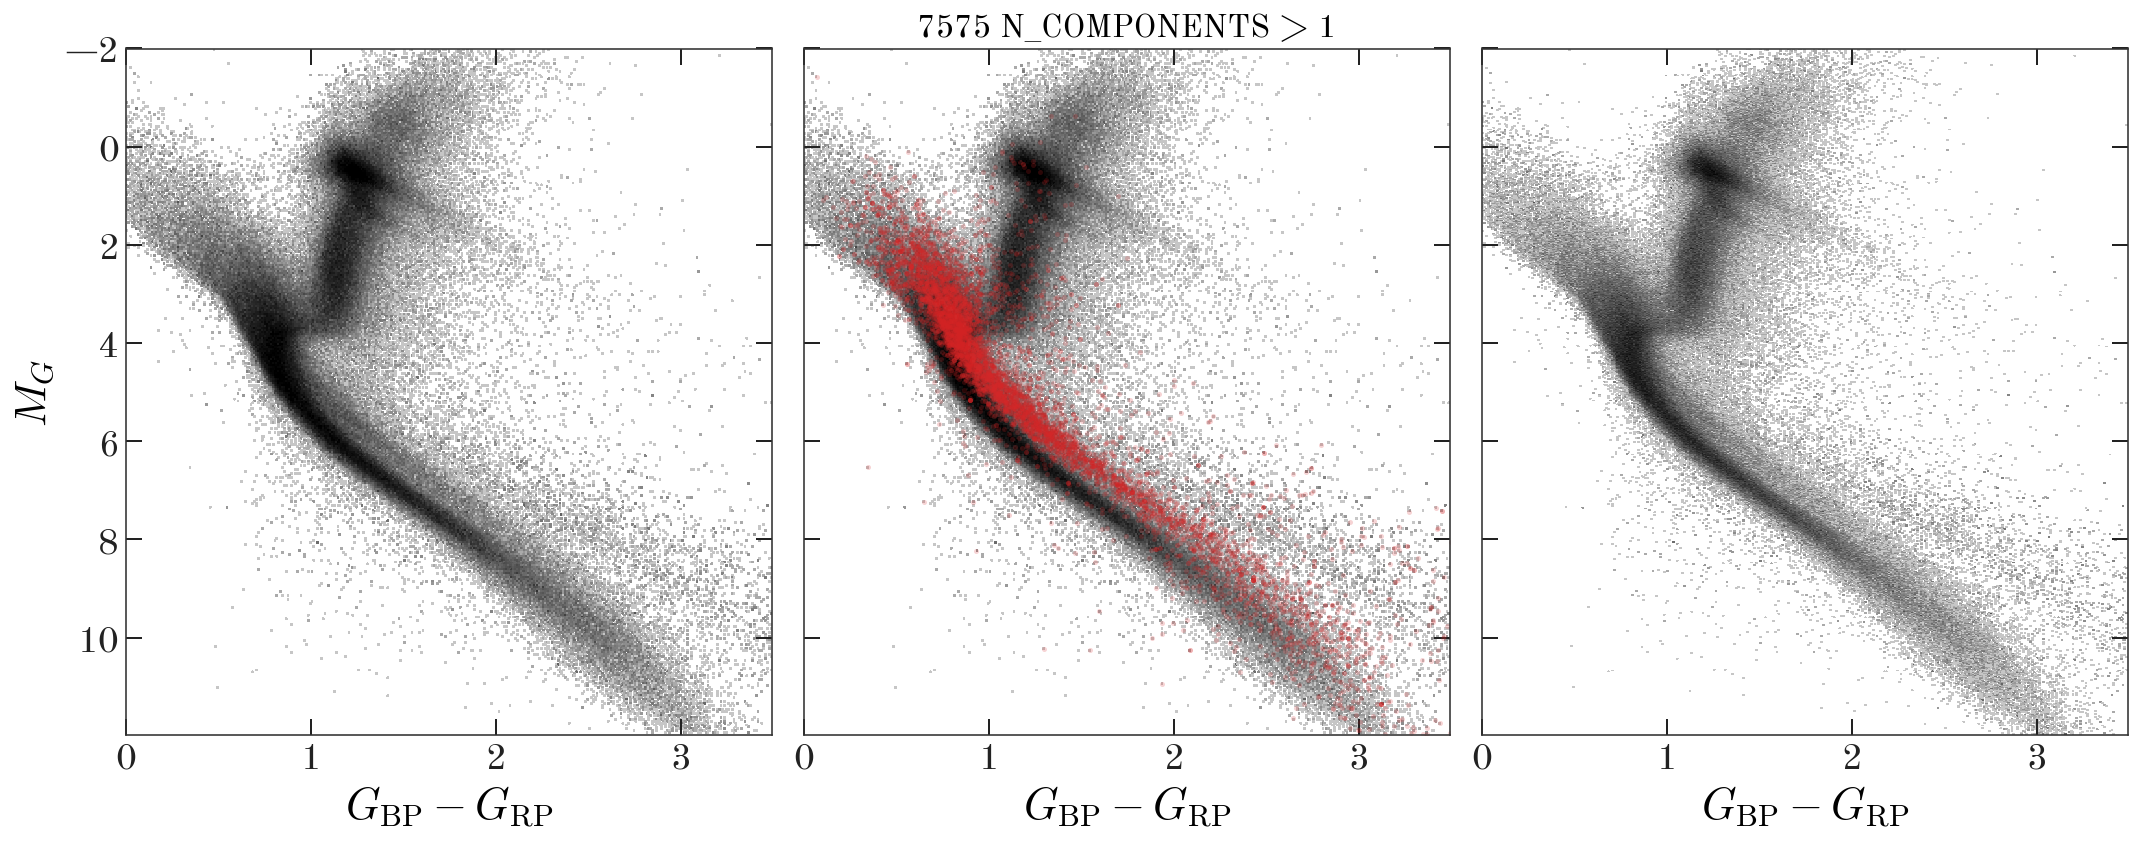

In [134]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6),
                         sharex=True, sharey=True)

H, xe, ye = np.histogram2d(
    BPRP, MG, bins=(np.arange(0., 3.5, 0.01),
                    np.arange(-2, 12, 0.04)))
norm = mpl.colors.LogNorm(vmin=0.1, vmax=1e2)
for ax in axes[:-1]:
    cs = ax.pcolormesh(xe, ye, H.T, 
                       norm=norm,
                       cmap='Greys')

ncomp_mask = allstar_sub['N_COMPONENTS'] > 1
ax.plot(BPRP[ncomp_mask], MG[ncomp_mask],
        ls='none', marker='o', mew=0, ms=2.5, 
        color='tab:red', alpha=0.2)

H2, xe, ye = np.histogram2d(
    BPRP[~ncomp_mask], MG[~ncomp_mask], 
    bins=(np.arange(0., 3.5, 0.01),
          np.arange(-2, 12, 0.02)))
axes[2].pcolormesh(xe, ye, H2.T, 
                   norm=norm,
                   cmap='Greys')

axes[0].set_xlim(xe.min(), xe.max())
axes[1].set_ylim(ye.max(), ye.min())

for ax in axes:
    ax.set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$')
axes[0].set_ylabel(r'$M_G$')

axes[1].set_title(f"{ncomp_mask.sum()} N_COMPONENTS > 1", fontsize=16)

fig.tight_layout()

In [100]:
ncomp_nvisit_mask = (allstar_sub['N_COMPONENTS'] > 1) & (allstar_sub['NVISITS'] > 15)
ncomp_nvisit_mask.sum()

291

In [106]:
allvisit_tmp = allvisit_new[np.sum(allvisit_new['RV_COMPONENTS'] != 0, axis=1) == 2]
len(allvisit_tmp)

19811

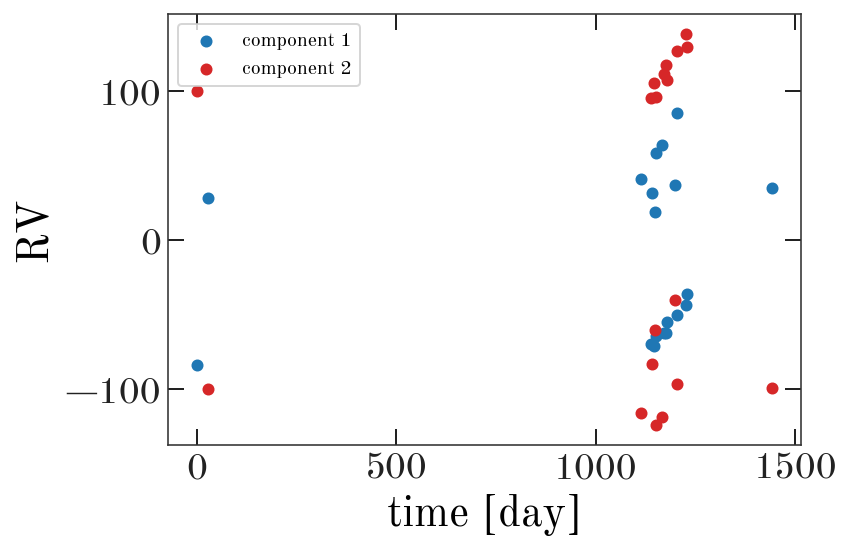

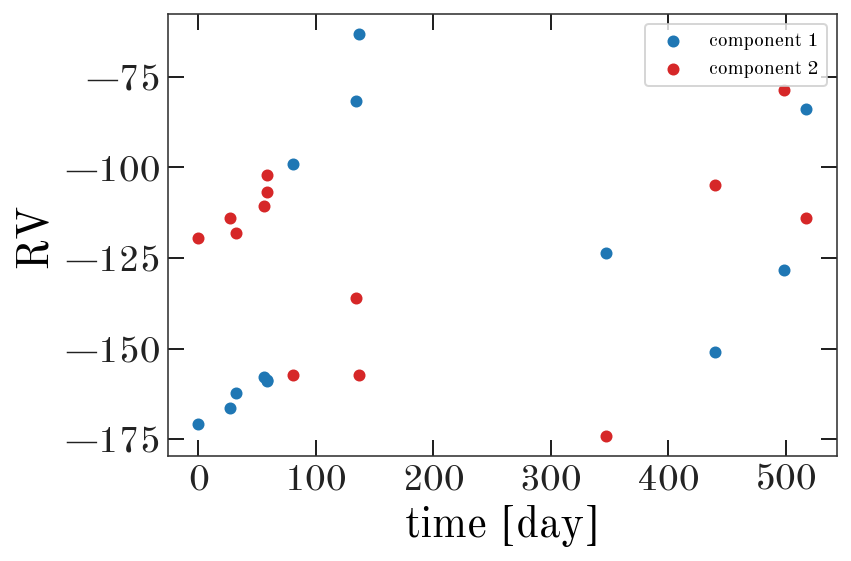

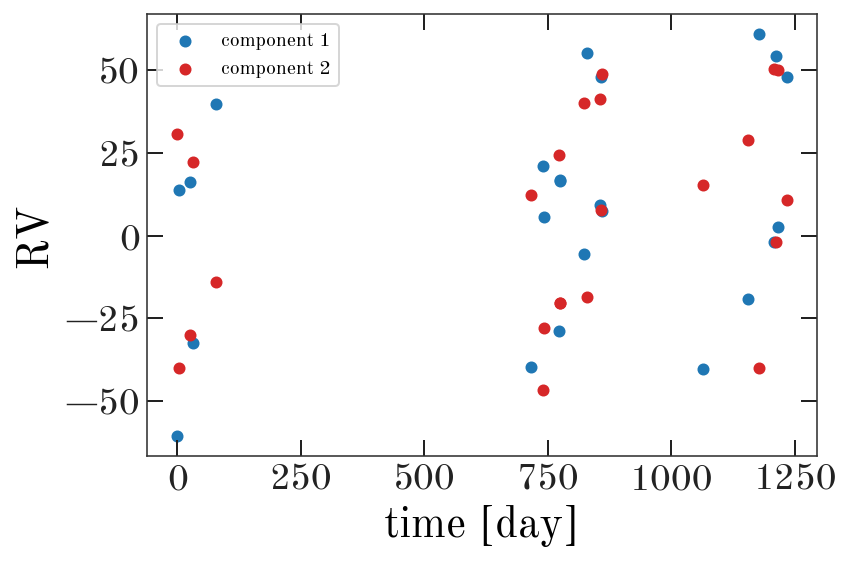

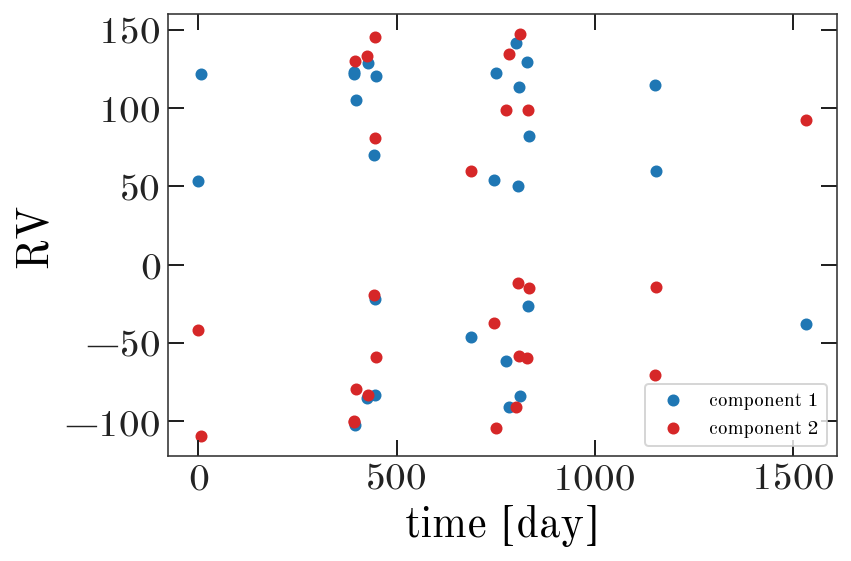

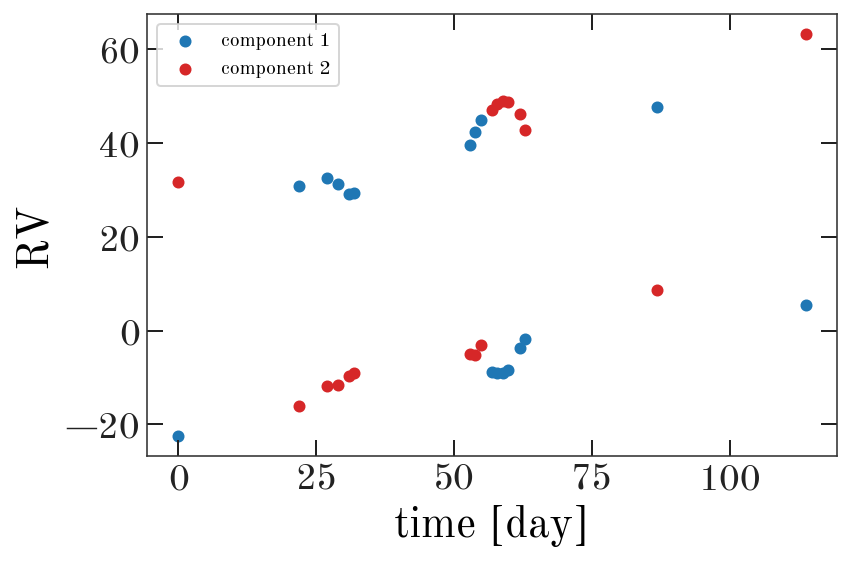

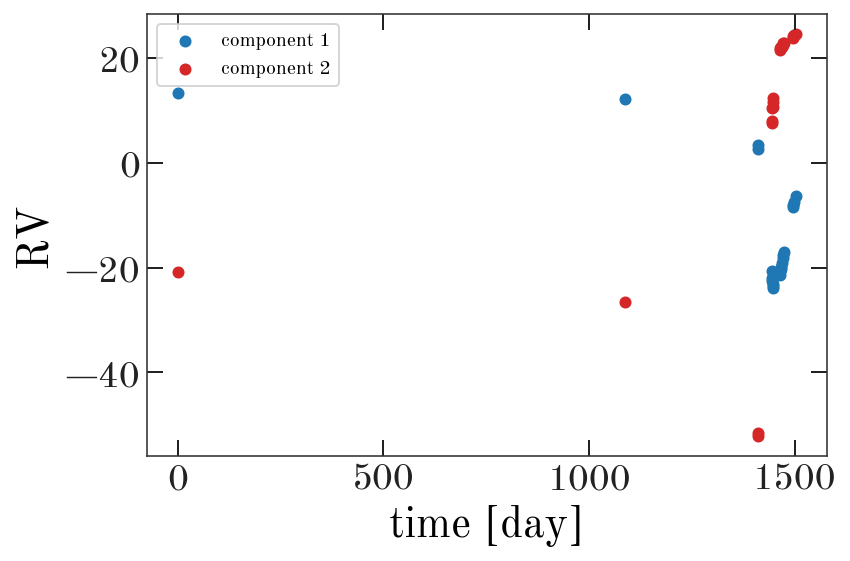

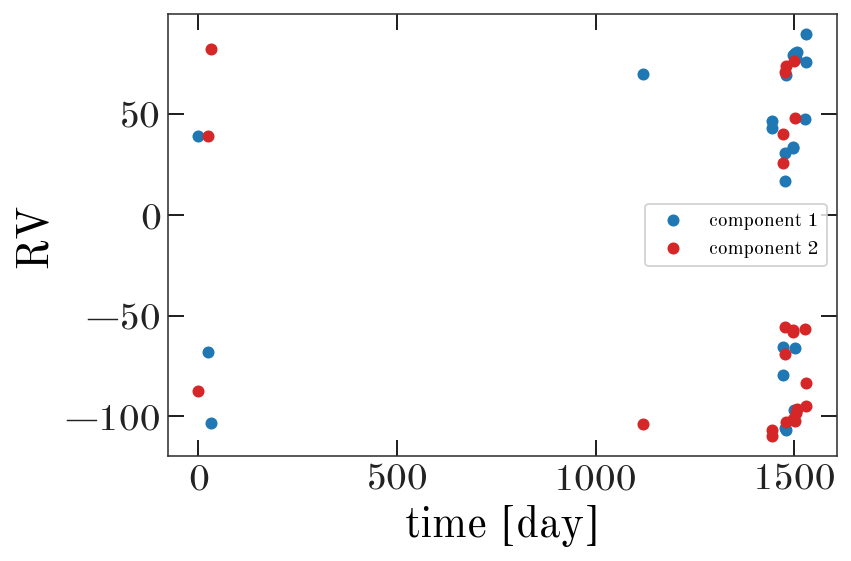

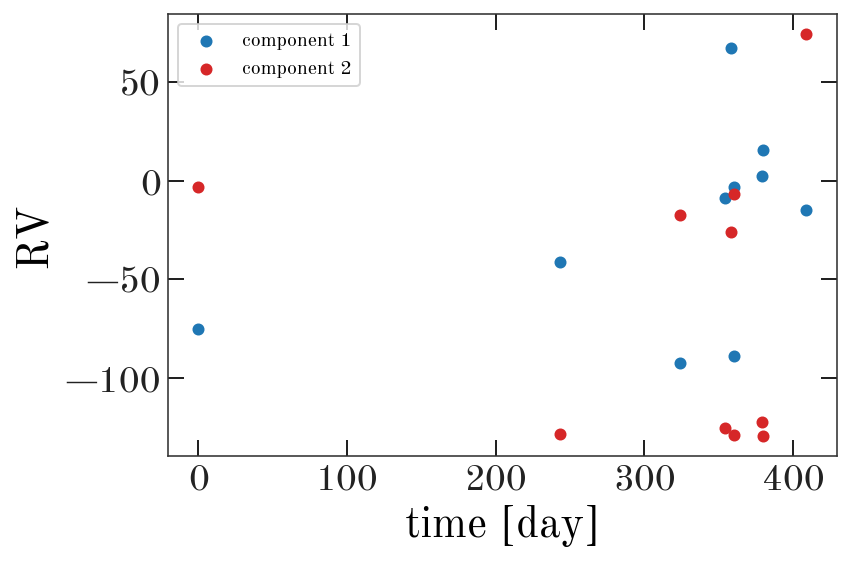

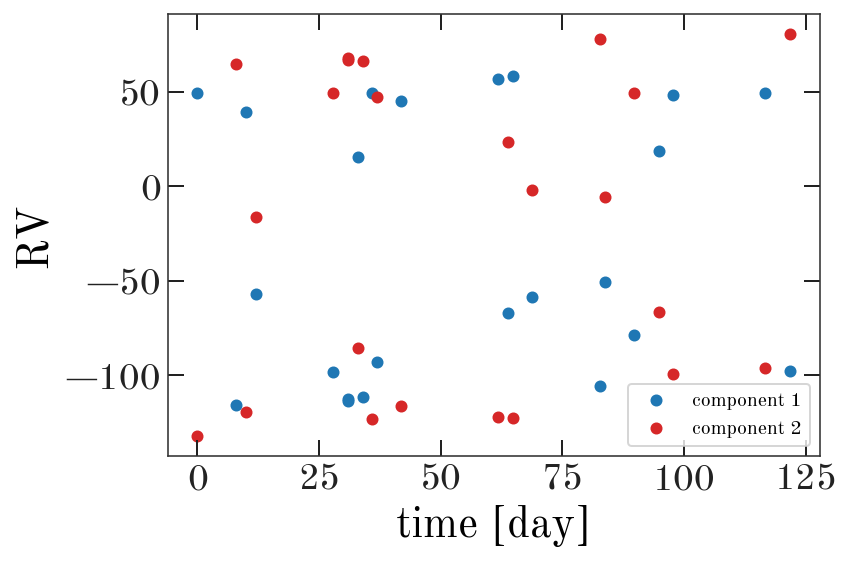

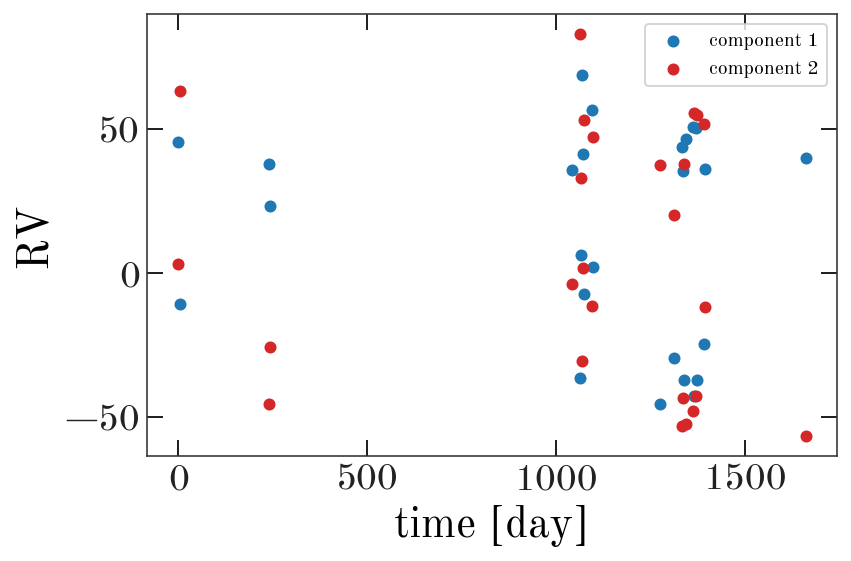

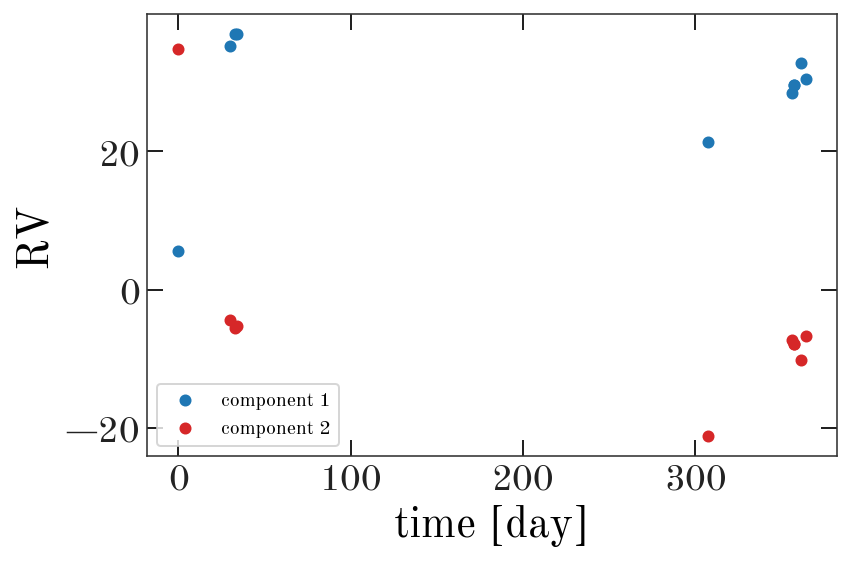

In [117]:
apogee_ids = allstar_sub['APOGEE_ID'][ncomp_nvisit_mask]

j = 0
for i, apid in enumerate(apogee_ids):
    visits = allvisit_tmp[np.isin(allvisit_tmp['APOGEE_ID'],
                                  apid)]
    visits = visits[np.any(visits['RV_COMPONENTS'] != 0, axis=1)]
    if len(visits) > 8:
        fig = plt.figure()
        plt.scatter(visits['JD'] - visits['JD'].min(), 
                    visits['RV_COMPONENTS'][:, 0], 
                    color='tab:blue', label='component 1')

        plt.scatter(visits['JD'] - visits['JD'].min(), 
                    visits['RV_COMPONENTS'][:, 1],
                    color='tab:red', label='component 2')
        
        plt.xlabel('time [day]')
        plt.ylabel('RV')
        
        plt.legend(loc='best')
        
        fig.set_facecolor('w')
        fig.tight_layout()
        
        j += 1
        
    if j > 10:
        break

Zoom in:

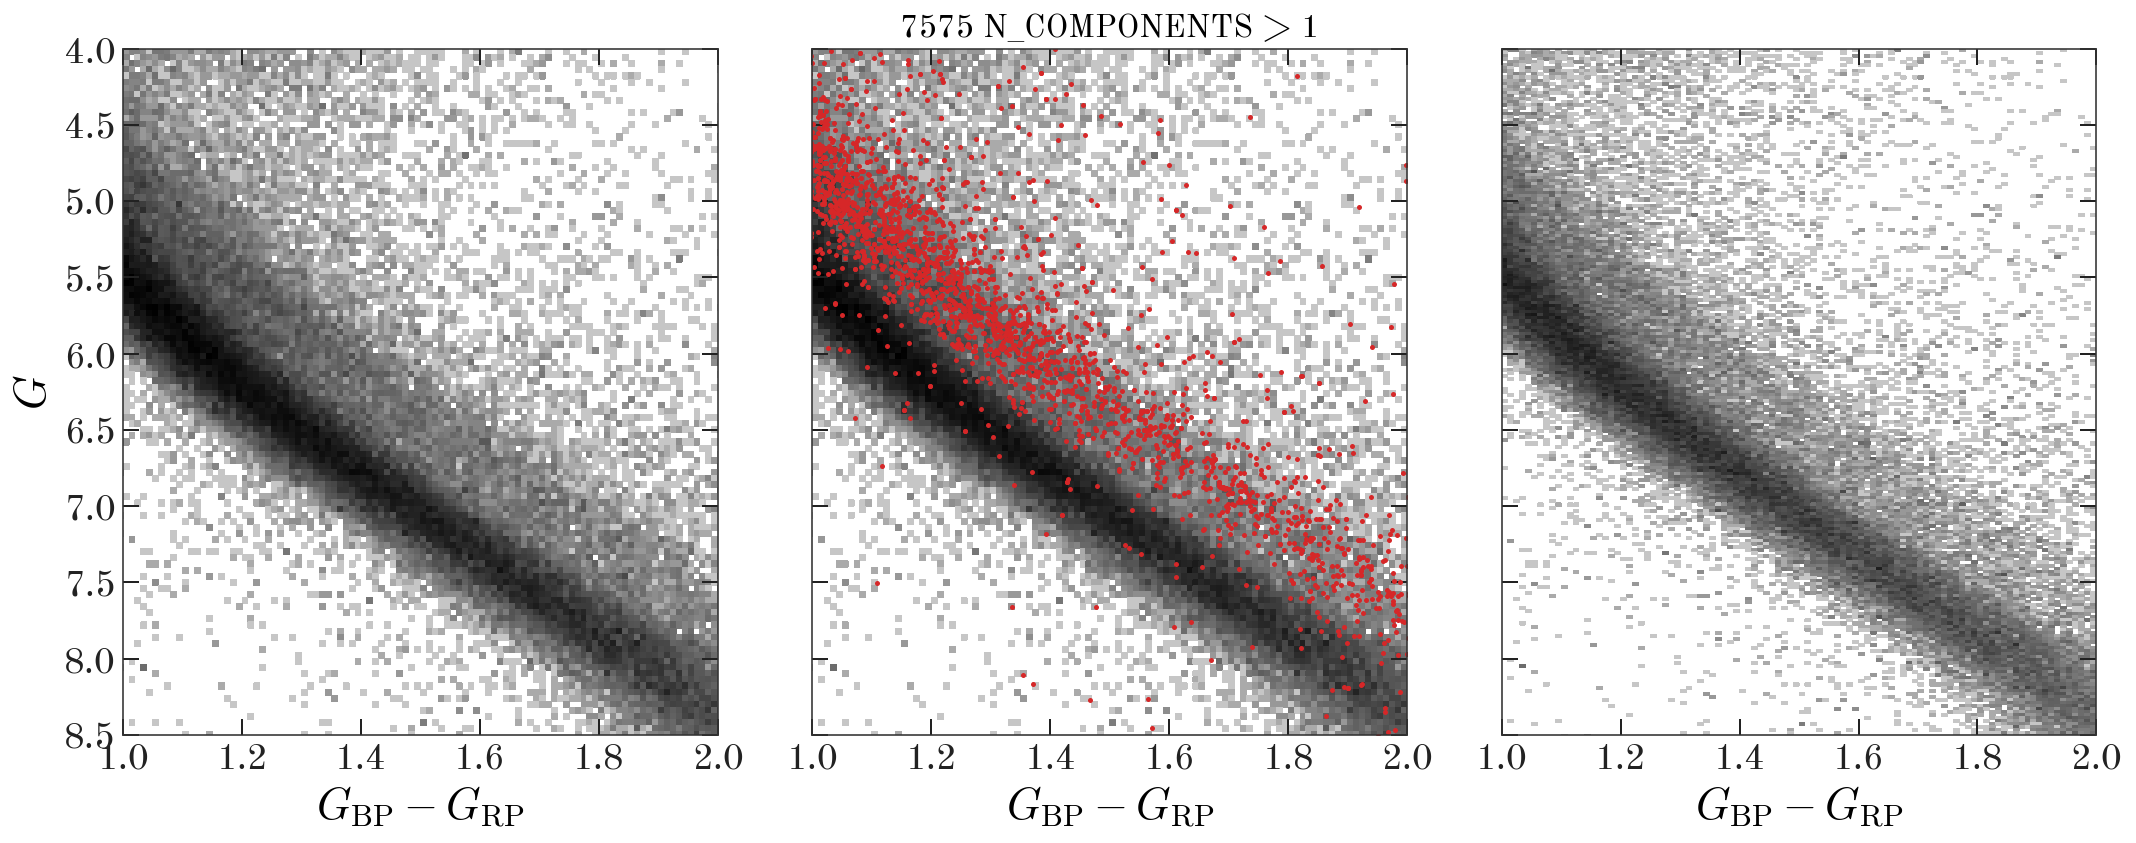

In [119]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6),
                         sharex=True, sharey=True)

H, xe, ye = np.histogram2d(
    BPRP, MG, bins=(np.arange(0., 3.5, 0.01),
                    np.arange(-2, 12, 0.04)))
norm = mpl.colors.LogNorm(vmin=0.1, vmax=1e2)
for ax in axes[:-1]:
    cs = ax.pcolormesh(xe, ye, H.T, 
                       norm=norm,
                       cmap='Greys')

ncomp_mask = allstar_sub['N_COMPONENTS'] > 1
ax.plot(BPRP[ncomp_mask], MG[ncomp_mask],
        ls='none', marker='o', mew=0, ms=2.5, 
        color='tab:red', alpha=1)

H2, xe, ye = np.histogram2d(
    BPRP[~ncomp_mask], MG[~ncomp_mask], 
    bins=(np.arange(0., 3.5, 0.01),
          np.arange(-2, 12, 0.02)))
axes[2].pcolormesh(xe, ye, H2.T, 
                   norm=norm,
                   cmap='Greys')

axes[0].set_xlim(1, 2)
axes[1].set_ylim(8.5, 4)

for ax in axes:
    ax.set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$')
axes[0].set_ylabel(r'$G$')

axes[1].set_title(f"{ncomp_mask.sum()} N_COMPONENTS > 1", fontsize=16)

fig.tight_layout()

In [127]:
huhs = allstar_sub[((BPRP>1.2) & (BPRP<1.4) & (MG > 6.4) & (MG < 7) & ncomp_mask)]

for apid in huhs['APOGEE_ID']:
    visits = allvisit_new[np.isin(allvisit_new['APOGEE_ID'],
                                  apid)]
    break

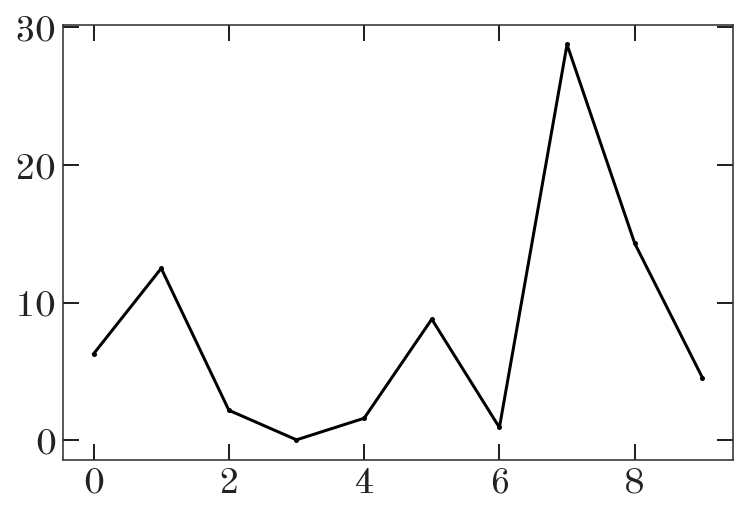

In [133]:
plt.plot(visits['JD'] - visits['JD'].min(), visits['VHELIO'])

## Compare to Gaia

In [169]:
from scipy.stats import binned_statistic_2d

In [172]:
tmp = allstar_new[(allstar_new['GAIA_RADIAL_VELOCITY'] > -999) & 
                  ((allstar_new['GAIA_PARALLAX'] / allstar_new['GAIA_PARALLAX_ERROR']) > 8) &
                  (allstar_new['GAIA_PHOT_BP_MEAN_MAG'] != allstar_new['GAIA_PHOT_RP_MEAN_MAG']) &
                  (np.abs(allstar_new['GLAT']) > 15)]
drv = tmp['GAIA_RADIAL_VELOCITY'] - tmp['VHELIO_AVG']

In [173]:
DM = coord.Distance(parallax=tmp['GAIA_PARALLAX']*u.mas).distmod.value
MG = tmp['GAIA_PHOT_G_MEAN_MAG'] - DM
BPRP = tmp['GAIA_PHOT_BP_MEAN_MAG'] - tmp['GAIA_PHOT_RP_MEAN_MAG']

In [190]:
from astropy.stats import median_absolute_deviation as mad

Text(0, 0.5, '$M_G$')

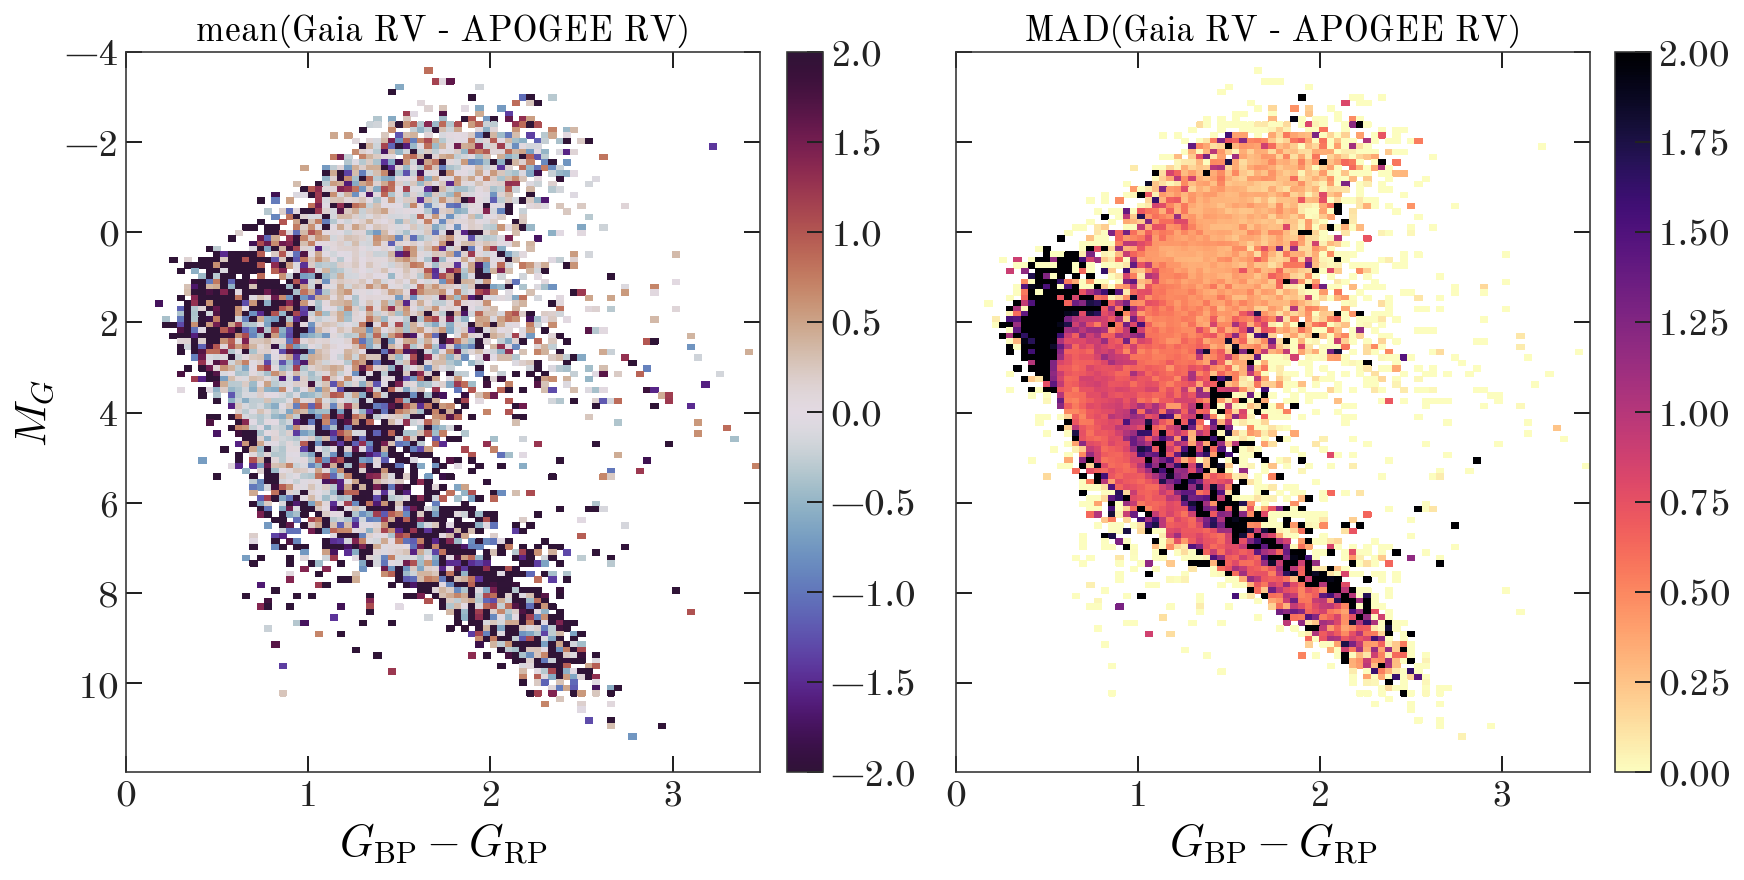

In [207]:
bins = (np.arange(0., 3.5, 0.04),
        np.arange(-4, 12, 0.12))

stat_mean = binned_statistic_2d(
    BPRP, MG, drv,
    bins=bins)

stat_std = binned_statistic_2d(
    BPRP, MG, drv,
    bins=bins,
    statistic=mad)

fig, axes = plt.subplots(1, 2, figsize=(12, 6),
                         sharex=True, sharey=True,
                         constrained_layout=True)

cs = axes[0].pcolormesh(stat_mean.x_edge, stat_mean.y_edge, 
                   stat_mean.statistic.T,
                   vmin=-2, vmax=2, cmap='twilight_shifted')
cb1 = fig.colorbar(cs, ax=axes[0], aspect=40)

cs = axes[1].pcolormesh(stat_std.x_edge, stat_std.y_edge, 
                   stat_std.statistic.T, 
                   vmin=0, vmax=2, cmap='magma_r')
cb2 = fig.colorbar(cs, ax=axes[1], aspect=40)

axes[0].set_xlim(stat_std.x_edge.min(), stat_std.x_edge.max())
axes[1].set_ylim(stat_std.y_edge.max(), stat_std.y_edge.min())

axes[0].set_title('mean(Gaia RV - APOGEE RV)', fontsize=18)
axes[1].set_title('MAD(Gaia RV - APOGEE RV)', fontsize=18)

for ax in axes:
    ax.set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$')
axes[0].set_ylabel(r'$M_G$')

Text(0, 0.5, 'LOGG')

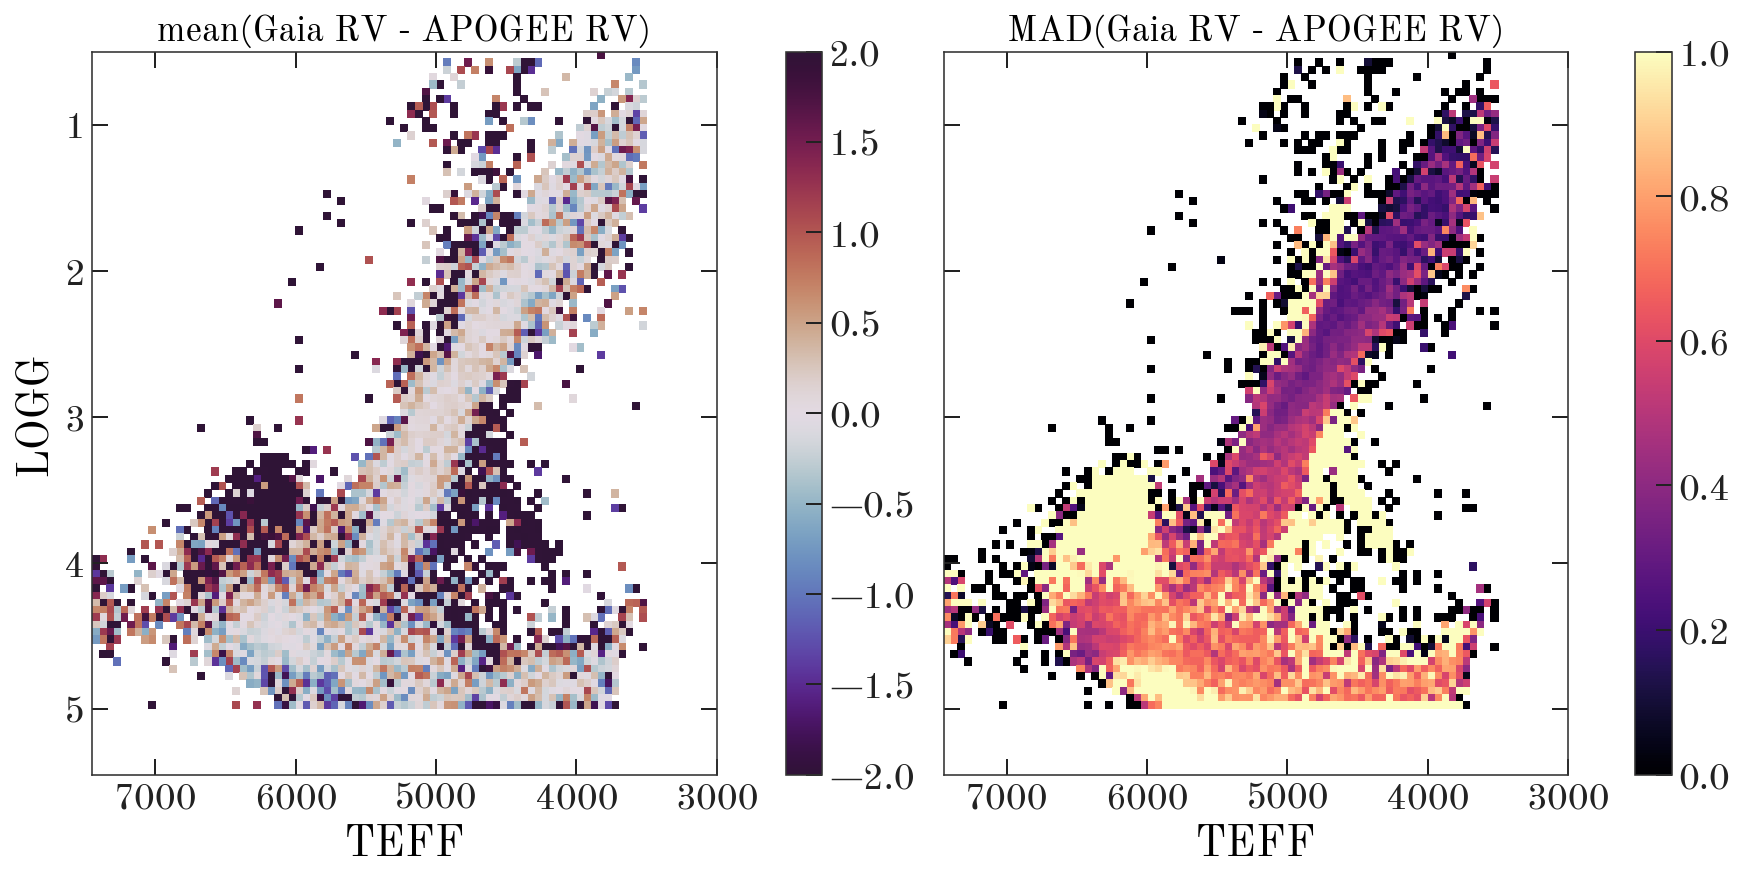

In [210]:
teff = tmp['RV_TEFF']
logg = tmp['RV_LOGG']

bins = (np.arange(3000., 7500, 50),
        np.arange(0.5, 5.5, 0.05))

stat_mean = binned_statistic_2d(
    teff, logg, drv,
    bins=bins)

stat_std = binned_statistic_2d(
    teff, logg, drv,
    bins=bins,
    statistic=mad)

fig, axes = plt.subplots(1, 2, figsize=(12, 6),
                         sharex=True, sharey=True,
                         constrained_layout=True)

cs = axes[0].pcolormesh(stat_mean.x_edge, stat_mean.y_edge, 
                   stat_mean.statistic.T,
                   vmin=-2, vmax=2,
                   cmap='twilight_shifted')
cb1 = fig.colorbar(cs, ax=axes[0], aspect=40)

cs = axes[1].pcolormesh(stat_std.x_edge, stat_std.y_edge, 
                   stat_std.statistic.T, 
                   vmin=0, vmax=2)
cb2 = fig.colorbar(cs, ax=axes[1], aspect=40)

axes[0].set_xlim(stat_mean.x_edge.max(), stat_mean.x_edge.min())
axes[1].set_ylim(stat_mean.y_edge.max(), stat_mean.y_edge.min())

axes[0].set_title('mean(Gaia RV - APOGEE RV)', fontsize=18)
axes[1].set_title('MAD(Gaia RV - APOGEE RV)', fontsize=18)

for ax in axes:
    ax.set_xlabel(r'TEFF')
axes[0].set_ylabel(r'LOGG')

In [209]:
allstar_new['RV_LOGG'].max()

5.0